# Experimenting with the NASnet CNN Architecture to classify melanoma images as Benign or Malignant

This was developed using Juypter Notebooks on my local computer, not on Google Colab. This was because Google Drive could not handle the large number of files in the training and testing sets and was causing a lot of instability.

## Experiment 1
- No data augmentation (besides pixel normalisation)
- Transfer learning using imagenet
- Batch size 20
- 50 epoches

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import load_model

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
batch_size = 20

In [19]:
train_generator = train_datagen.flow_from_directory(
    "./train",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary"
)

Found 700 images belonging to 2 classes.


In [20]:
validation_generator = validation_datagen.flow_from_directory(
    "./validation",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary"
)

Found 234 images belonging to 2 classes.


In [21]:
test_generator = test_datagen.flow_from_directory(
    "./test",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 234 images belonging to 2 classes.


In [7]:
nas_net = NASNetMobile(
    weights="imagenet", 
    include_top=False, 
    input_shape=(224, 224, 3),
    pooling="max"
)

In [69]:
model = tf.keras.models.Sequential()
model.add(nas_net)
model.add(tf.keras.layers.Dense(units=224, activation='relu'))
model.add(tf.keras.layers.Dense(units=224, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [70]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 1056)              4269716   
_________________________________________________________________
dense_12 (Dense)             (None, 224)               236768    
_________________________________________________________________
dense_13 (Dense)             (None, 224)               50400     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 225       
Total params: 4,557,109
Trainable params: 4,520,371
Non-trainable params: 36,738
_________________________________________________________________


In [71]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=1e-4),
    metrics=['acc']
)

In [16]:
checkpoint_directory = "./saved_models/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(checkpoint_directory, monitor="val_acc", verbose=1, save_best_only="max")
callbacks_list = [checkpoint]

In [16]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs = 50,
    verbose=2,
    callbacks=callbacks_list
)

Epoch 1/50
35/35 - 139s - loss: 0.7176 - acc: 0.6314 - val_loss: 0.7308 - val_acc: 0.6068

Epoch 00001: val_acc improved from -inf to 0.60684, saving model to ./saved_models\weights-01-0.61.hdf5
Epoch 2/50
35/35 - 104s - loss: 0.3760 - acc: 0.8343 - val_loss: 0.6594 - val_acc: 0.6368

Epoch 00002: val_acc improved from 0.60684 to 0.63675, saving model to ./saved_models\weights-02-0.64.hdf5
Epoch 3/50
35/35 - 103s - loss: 0.2477 - acc: 0.9086 - val_loss: 0.6518 - val_acc: 0.6752

Epoch 00003: val_acc improved from 0.63675 to 0.67521, saving model to ./saved_models\weights-03-0.68.hdf5
Epoch 4/50
35/35 - 104s - loss: 0.1526 - acc: 0.9400 - val_loss: 0.7152 - val_acc: 0.6453

Epoch 00004: val_acc did not improve from 0.67521
Epoch 5/50
35/35 - 104s - loss: 0.0983 - acc: 0.9757 - val_loss: 0.6850 - val_acc: 0.6709

Epoch 00005: val_acc did not improve from 0.67521
Epoch 6/50
35/35 - 104s - loss: 0.0537 - acc: 0.9843 - val_loss: 0.7294 - val_acc: 0.6709

Epoch 00006: val_acc did not improve

In [8]:
def plotAccAndVal(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [18]:
model.save("experiment1.h5")

In [22]:
saved_model = load_model("./saved_models/experiment_1/weights-43-0.71.hdf5")

In [23]:
probabilities = saved_model.predict(test_generator, 234)

In [24]:
y_true = np.array([0] * 117 + [1] * 117)
y_pred = probabilities > 0.5

confusionMatrix = confusion_matrix(y_true, y_pred)

In [25]:
def visualiseConfusionMatrix(confusionMatrix, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        confusionMatrix, 
        annot=True, 
        fmt=".3f", 
        linewidths=.75, 
        square = True, 
        cmap = "Blues_r",
        xticklabels=["Benign", "Malignant"],
        yticklabels=["Benign", "Malignant"]
    )
    plt.ylabel("Actual classification")
    plt.xlabel("Predicted predicted")
    plt.title(title, size = 15)

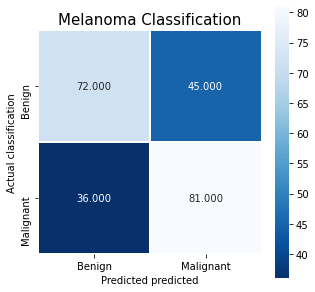

In [26]:
visualiseConfusionMatrix(confusionMatrix, "Melanoma Classification")

In [27]:
confusionMatrix

array([[72, 45],
       [36, 81]], dtype=int64)

A positive in this experiment is a sample being classified as benign. So a false positive is a case being classified by our model as being benign when it was actually malignant.

In [28]:
fpr = confusionMatrix[1][0] / (confusionMatrix[1][0] + confusionMatrix[1][1])
print(f"FPR: {round(fpr*100, 2)}%")

FPR: 30.77%


In [29]:
test_accuracy = (confusionMatrix[0][0] + confusionMatrix[1][1]) / (confusionMatrix[0][0] + confusionMatrix[0][1] + confusionMatrix[1][0] + confusionMatrix[1][1])
print(f"Test accuracy: {round(test_accuracy*100, 2)}%")

Test accuracy: 65.38%
